In this notebook 320x320 CXR jpg and labels are read from Seoul CXRs. The model previously trained to classify mortality on the Madrid CXR is used to extract 64 features and output the prediction from the Seoul CXR. 

## Environment

In [ ]:
!pip3 install sklearn
!pip3 install gcsfs
!pip3 install shap -q
!pip3 install seaborn
!pip3 install tableone -q
!pip3 install fsspec
!pip3 install --upgrade ipykernel install h5py==2.10.0
!pip3 install tensorflow==2.4.1

import os, sys, math
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.python.lib.io import file_io
import tensorflow.keras.backend as K
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import CustomObjectScope
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
import pandas as pd
import random
import gcsfs

# import cv2

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

print("Tensorflow version " + tf.__version__)
print("Numpy version " + np.__version__)
print("gcsfs version " + gcsfs.__version__)

     |████████████████████████████████| 112kB 24.7MB/s 
     |████████████████████████████████| 1.3MB 40.7MB/s 
     |████████████████████████████████| 296kB 50.8MB/s 
     |████████████████████████████████| 143kB 54.7MB/s 
     |████████████████████████████████| 358kB 16.6MB/s 
     |████████████████████████████████| 122kB 16.4MB/s 
Requirement already up-to-date: h5py==2.10.0 in /usr/local/lib/python3.7/dist-packages (2.10.0)
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.0 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


Tensorflow version 2.4.1
Tensorflow version 2.4.1
Numpy version 1.19.5
gcsfs version 0.7.2


## Configuration

In [ ]:
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label, name) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')

    sq_image= np.squeeze(image.numpy().astype(np.uint8))

    plt.imshow(sq_image,cmap='gray', vmin=0, vmax=255)
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [ ]:
IMAGE_SIZE = [320,320]

In [ ]:
GCS_PATTERN_TEST = 'gs://snuh_cxr/*/*.jpg'
SHARDS_TEST = 1
GCS_OUTPUT_TEST = 'gs://snuh_cxr/test-'
CLASSES = [b'ALIVE', b'EXPIRED'] # it maps to the labels in the data (folder names)

## Read images and labels

In [ ]:
def decode_jpeg_and_label_and_name(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse cxr name from containing directory
  tmp_str = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = tmp_str.values[-2]
  return image, label, filename

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN_TEST))
shard_size_test = math.ceil(1.0 * nb_images / SHARDS_TEST)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS_TEST, shard_size_test))


filenames = tf.data.Dataset.list_files(GCS_PATTERN_TEST, seed=123) # This also shuffles the images
dataset_test = filenames.map(decode_jpeg_and_label_and_name, num_parallel_calls=None)

Pattern matches 330 images which will be rewritten as 1 .tfrec files containing 330 images each.


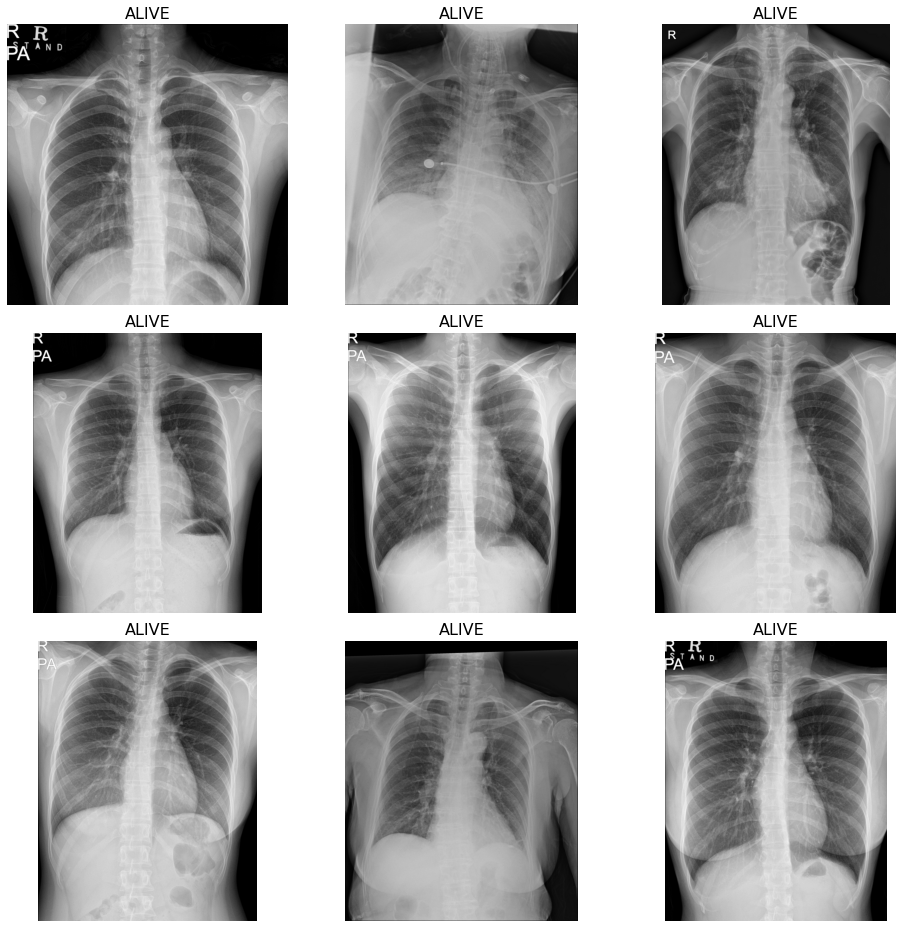

In [ ]:
display_9_images_from_dataset(dataset_test)

In [ ]:
TARGET_SIZE = [320, 320]

def resize_and_crop_image(image, label, name):
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label, name
  
dataset_test_crop = dataset_test.map(resize_and_crop_image, num_parallel_calls=None)  

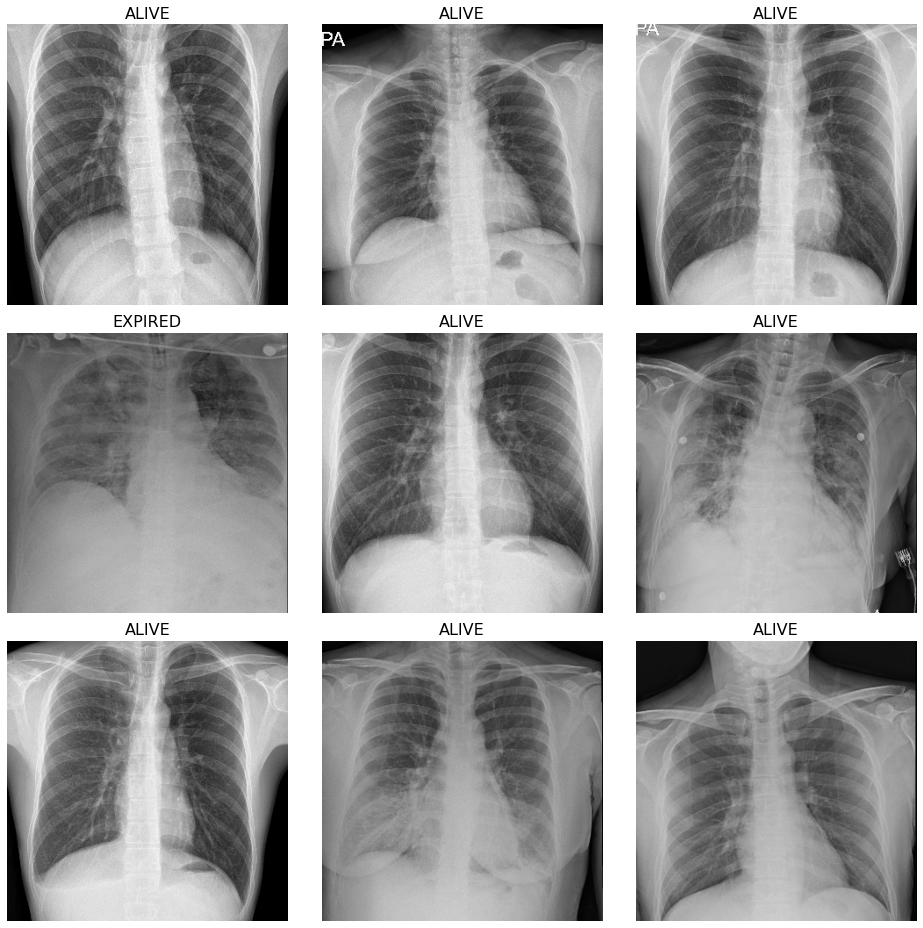

In [ ]:
 display_9_images_from_dataset(dataset_test_crop)

## Write dataset to TFRecord files

In [ ]:
def recompress_image(image, label, name):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width, name


dataset_test_3 = dataset_test_crop.map(recompress_image, num_parallel_calls=None)
dataset_test_3 = dataset_test_3.batch(shard_size_test) # sharding: there will be one "batch" of images per file 

In [ ]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width, name):  
  class_num = np.argmax(np.array(CLASSES)==label) # order defined in CLASSES
  one_hot_class = np.eye(len(CLASSES))[class_num]    

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()), # variable length  list of floats, n=len(CLASSES)
      "name":         _bytestring_feature([name])

  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
print("Writing Testing TFRecords")
for shard, (image, label, height, width, name) in enumerate(dataset_test_3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT_TEST + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i],
                            name.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing Testing TFRecords
Wrote file gs://snuh_cxr/test-00-330.tfrec containing 330 records


#Load model

In [ ]:
!sudo apt-get install wget
!wget 'https://storage.googleapis.com/new_cxr_30/models_cxr_models_modelsent_110221.h5'
# previous version of the model 'model-004' produced a lot of columns with all 0.
# this version utilizes a new model shared by Joy on 110221

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
--2021-02-26 21:55:23--  https://storage.googleapis.com/new_cxr_30/models_cxr_models_modelsent_110221.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.8.16, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35225912 (34M) [application/octet-stream]
Saving to: ‘models_cxr_models_modelsent_110221.h5’

models_cxr_models_m 100%[===================>]  33.59M   105MB/s    in 0.3s    

2021-02-26 21:55:23 (105 MB/s) - ‘models_cxr_models_modelsent_110221.h5’ saved [35225912/35225912]



In [ ]:
model = tf.keras.models.load_model('models_cxr_models_modelsent_110221.h5', compile=False)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

In [ ]:
# model.summary()

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    #image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.decode_jpeg(example['image'], channels=1)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range

    #INPUT_HWC = (320, 320, 1)

    #image = tf.reshape(image, INPUT_HWC) # explicit size will be needed for TPU

    #image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU

    image = tf.reshape(image, [*IMAGE_SIZE, 1])

    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [2]) # specify number of classes


    return image, one_hot_class[1]

def read_tfrecord_name(example):
    features = {
        "name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, features)
    name = example['name']

    return name

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=None)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=None)
  return dataset

def load_dataset_name(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=None)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord_name, num_parallel_calls=None)
  return dataset

In [ ]:
BATCH_SIZE = nb_images
# Data loader/iterator
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
    dataset = dataset.map(data_augment, num_parallel_calls=None)
    
    dataset2 = dataset.map(data_augment, num_parallel_calls=None)
    dataset = dataset.concatenate(dataset2)

    dataset = dataset.shuffle(256)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets



In [ ]:
validation_dataset = get_batched_dataset(filename, train=False)
dataset_name = load_dataset_name(filename)

# Prediction

In [ ]:
predictions = model.predict(validation_dataset)

In [ ]:
for digits, labels in validation_dataset:
    labels = labels.numpy()

In [ ]:
CLASSES = ['ALIVE', 'EXPIRED']

import sklearn.metrics

# y_label = np.array(CLASSES)[some_labels.astype(int)].tolist()

y_label = np.array(CLASSES)[labels.astype(int)].tolist() 

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_label, predictions, pos_label = 'EXPIRED')
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 
predicted_class = np.zeros(len(predictions), dtype=int)
predicted_class[predictions[:,0] < optimal_threshold] = 0
predicted_class[predictions[:,0] >= optimal_threshold] = 1
predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

## use 0.5 as cut-point 
# predicted_class[predictions < 0.5] = 0
# predicted_class[predictions >= 0.5] = 1
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(labels, predicted_class).ravel()
roc_auc = sklearn.metrics.roc_auc_score(y_label, predictions)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.90
Sensitivity: 1.00
Specificity: 0.82
PPV: 0.08
NPV: 1.00
F1-score: 0.15
Accuracy: 0.82
tn, fp, fn, tp: (267, 58, 0, 5)


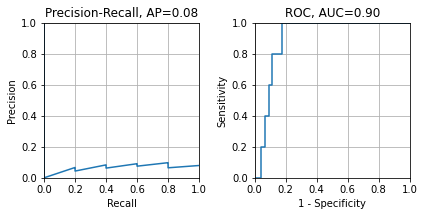

In [ ]:
fig, axes = plt.subplots(1, 2)

# Plot the precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_label, predictions,pos_label = 'EXPIRED')
average_precision = sklearn.metrics.average_precision_score(y_label, predictions,pos_label = 'EXPIRED')

pr_axis = axes[0]
pr_axis.plot(recall, precision)
pr_axis.set_aspect('equal')
pr_axis.set_xlim(0, 1)
pr_axis.set_ylim(0, 1)
pr_axis.set_xlabel('Recall')
pr_axis.set_ylabel('Precision')
pr_axis.set_title('Precision-Recall, AP={:.2f}'.format(average_precision))
pr_axis.grid(True)

# Plot the ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_label, predictions,pos_label = 'EXPIRED')
roc_auc = sklearn.metrics.roc_auc_score(y_label, predictions)

roc_axis = axes[1]
roc_axis.plot(fpr, tpr)
roc_axis.set_aspect('equal')
roc_axis.set_xlim(0, 1)
roc_axis.set_ylim(0, 1)
roc_axis.set_xlabel('1 - Specificity')
roc_axis.set_ylabel('Sensitivity')
roc_axis.set_title('ROC, AUC={:.2f}'.format(roc_auc))
roc_axis.grid(True)

plt.tight_layout()

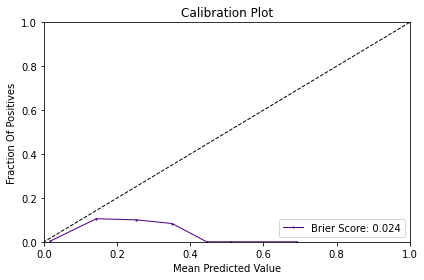

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

title_calibration='Calibration Plot'
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--",linewidth=1)

fraction_of_positives, mean_predicted_value = calibration_curve(labels,predictions,n_bins=10)
brier_score = brier_score_loss(labels,predictions)
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",markersize=1,label=f'Brier Score: {np.round(brier_score,3)}',color='indigo',linewidth=1)
plt.legend(loc="lower right")
plt.tight_layout()

# Output the image features, labels, and file names



In [ ]:
new_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
inter_output = new_model.predict(validation_dataset)

In [ ]:
np.savetxt("snuh_image_feature.csv", inter_output, delimiter=",")

In [ ]:
np.savetxt("snuh_image_label.csv", labels, delimiter=",")

In [ ]:
all_names =[];
for names in dataset_name:
    all_names.append(names.numpy())
np.savetxt("snuh_image_names.csv", all_names, delimiter=",", fmt ='% s')